<a href="https://colab.research.google.com/github/chaos44/gan-in-action/blob/main/chap10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Chapter 10: Adversarial Examples
# 0.8.0v2, 0.1a1, 0.1a2, 0.1b1, 0.2, 0.3, 0.3.1, 0.3.2, 0.3.3, 0.3.4, 0.3.5, 0.4.1, 0.5.0, 0.6.0, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.1, 0.9.0, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.10.0, 0.11.0, 0.11.1, 0.12.1, 0.12.2, 0.12.3, 0.12.4, 0.13.0, 0.14.0, 0.15.0, 1.0.0, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.3.2, 1.4.0, 1.5.0, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.8.0, 2.0.0b0, 2.0.0rc0, 2.0.0, 2.1.0, 2.2.0, 2.2.1, 2.3.0, 2.4.0, 3.0.0b0, 3.0.0b1, 3.0.0, 3.0.1, 3.0.2, 3.0.4, 3.1.1, 3.2.0, 3.2.1
!pip install foolbox==2.0.0rc0

# tensorflow2系でfoolbox.models.KerasModel()でエラーになるため、1系を使う
# tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.エラーの解消
!pip install tensorflow==1.13.1
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 2.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from foolbox.criteria import Misclassification, ConfidentMisclassification
from keras.preprocessing import image as img
from keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import foolbox
import pprint as pp
import keras
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [ ]:
## If you are in Colab, uncomment these two to get the files

In [ ]:
!wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
!wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0896.jpg

--2020-10-15 05:56:02--  https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GANs-in-Action/gans-in-action/Chapter-10/chapter-10/DSC_0897.jpg [following]
--2020-10-15 05:56:02--  https://raw.githubusercontent.com/GANs-in-Action/gans-in-action/Chapter-10/chapter-10/DSC_0897.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3028795 (2.9M) [image/jpeg]
Saving to: ‘DSC_0897.jpg.17’

DSC_0897.jpg.17     100%[===================>]   2.89M  10.5MB/s    in 0.3s    

2020-10-15 05:56:03 (10.5 MB/s) - ‘DSC_0897.jpg.17’ saved 

In [ ]:
## Helper functions

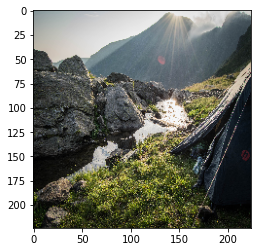

In [ ]:
def load_image(img_path: str):
  image = img.load_img(img_path, target_size=(224, 224))
  plt.imshow(image)
  x = img.img_to_array(image)
  return x

image = load_image('DSC_0897.jpg')

In [ ]:
## Attacking one image

In [ ]:
# instantiate model
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
# create the foolbox model object from the Keras model
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

# We make the image (1, 224, 224, 3) so that it fits ResNet50
# which expects images for predictions to be in batches
to_classify = np.expand_dims(image, axis=0)
# We call predict and print the results
preds = kmodel.predict(to_classify)
print('Original predictions redicted:', pp.pprint(decode_predictions(preds, top=20)[0]), '\n')
# get the index of the highest number, as a label to be used later
label = np.argmax(preds)

# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
image = image[:, :, ::-1]
# create the attack object, setting high misclassification criteria 
attack = foolbox.attacks.FGSM(fmodel, threshold=.9, criterion=ConfidentMisclassification(.9))
# apply attack on source image
adversarial = attack(image, label)

# get the new predictions on the advesarial image
new_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
print('Adversarial predictions:', pp.pprint(decode_predictions(new_preds, top=20)[0]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[('n03792972', 'mountain_tent', 0.68727505),
 ('n09399592', 'promontory', 0.07355865),
 ('n09468604', 'valley', 0.07171795),
 ('n04606251', 'wreck', 0.025214508),
 ('n09428293', 'seashore', 0.018810676),
 ('n01498041', 'stingray', 0.010203825),
 ('n04366367', 'suspension_bridge', 0.00910297),
 ('n02077923', 'sea_lion', 0.008893936),
 ('n09472597', 'volcano', 0.00771579),
 ('n09421951', 'sandbar', 0.0056634475),
 ('n09193705', 'alp', 0.005281756),
 ('n09256479', 'coral_reef', 0.005070689),
 ('n03042490', 'cliff_dwelling', 0.0048538684),
 ('n03788365', 'mosquito_net', 0.0040941807),
 ('n03450230', 'gown', 0.003981214),
 ('n09246464', 'cliff', 0.0034005924),
 ('n04507155', 'umbrella', 0.0025982112),
 ('n09332890', 'lakeside', 0.0024168892),
 ('n02951358', 'canoe', 0.0020540748),
 ('n03160309', 'dam', 0.0020333943)]
Original predictions redicted: None 

[('n09472597', 'vo

In [ ]:
## Side-by-side comparison

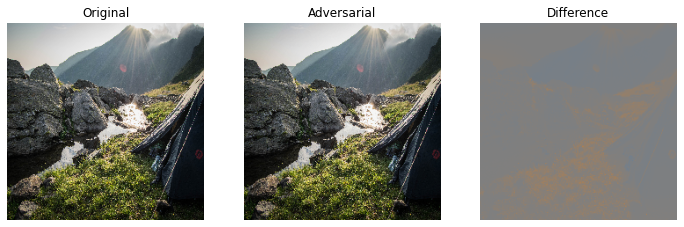

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image[:,:,::-1] / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [ ]:
## Here we just load the means and variances for Gaussian noise.
# More is in the `get_vals_for_noise.py` script in this chapter.

In [ ]:
'''
This file serves as a way to ensure that we start from a meaningful point for ResNet50 attack.

If you are not convinced and think this may be making the problem too trivial—though consider
why as an attacker you would not use that—checkout the InceptionV3 example.
There we make use of no pre-stored values for attacks.

In principle, the ResNet50 attack should replicate even without this initialization, but it
is then not guaranteed
'''
# We get the standard Imports
import numpy as np
from keras.preprocessing import image as img
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
import foolbox
import pandas as pd
import keras

# Initialize our ResNet50 pre-trained model and our DataFrame to store the objects into 
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')

mu_list = range(50, 200, 10)
sigma_list = range(10, 100, 2)
storage_df = pd.DataFrame()

# In a for loop generate a bunch of mean and variances values
for mu, sigma in zip(mu_list, sigma_list):
    # sample for this particular mean and var from normal at that location
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    # preprocess
    rand_noise = np.clip(preprocess_input(rand_noise), 0, 255.)
    # get raw predictions
    noise_preds = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    # get human readable
    predictions = decode_predictions(noise_preds, top=20)[0]
    # store these predictions in a dataframe format 
    new_df = pd.DataFrame(predictions, columns=['id','class','prediction'])
    new_df['sigma'] = sigma
    new_df['mu'] = mu
    # add this data point to the data frame
    storage_df = pd.concat([new_df, storage_df])


storage_df.to_csv('initialization_vals_for_noise.csv')

In [ ]:
max_vals = pd.read_csv('initialization_vals_for_noise.csv')

## Now run the evaluation script on `ResNet50`

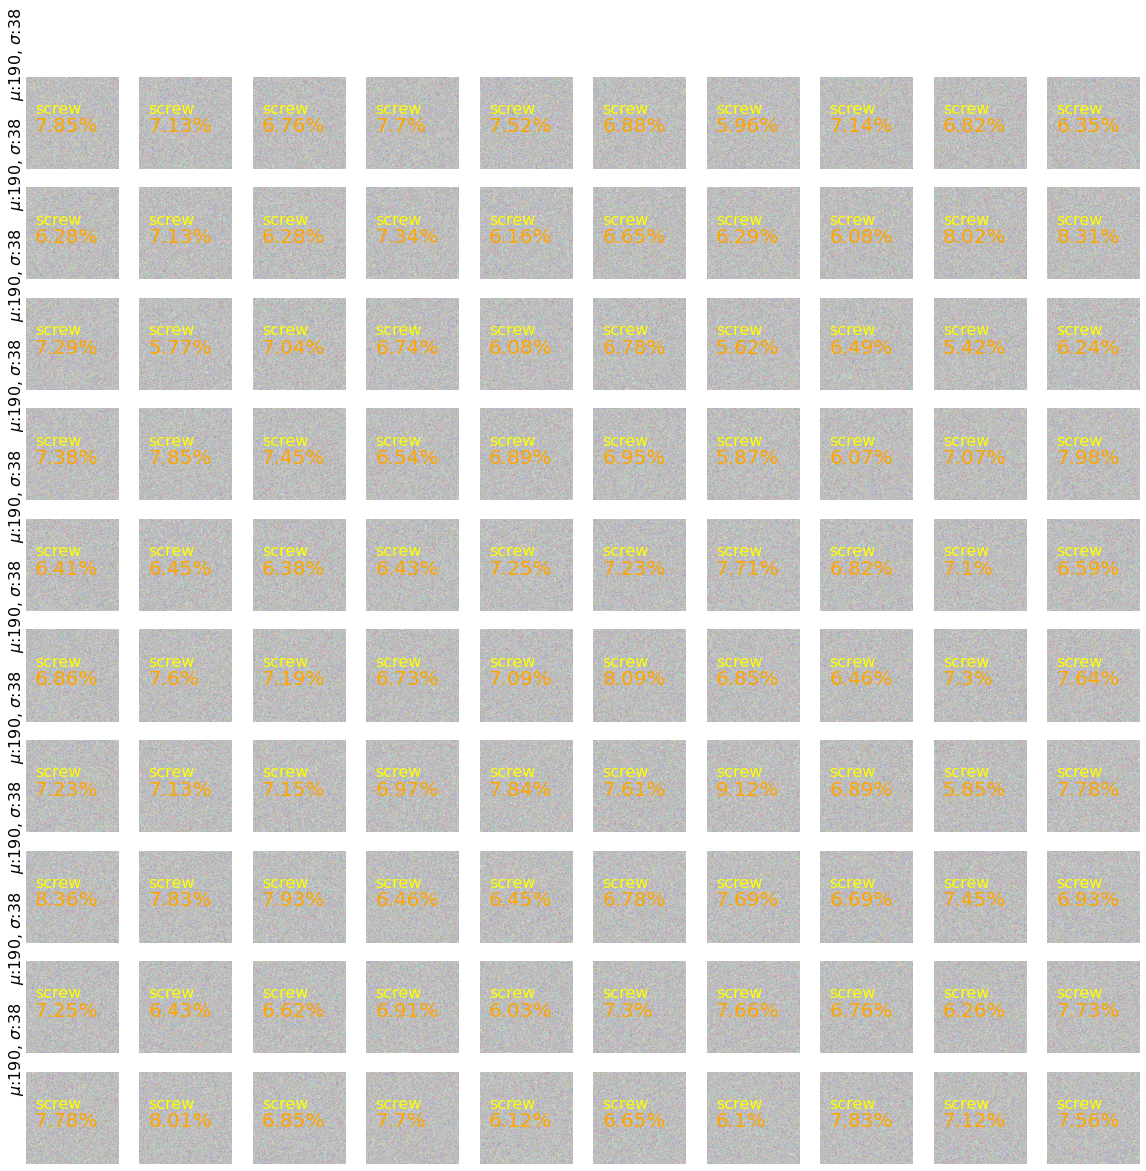

In [ ]:
fig = plt.figure(figsize=(20,20))
# these are just lists of means and variances as floats
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)
conf_list = []

# this is the core function that 
def make_subplot(x, y, z, new_row=False):
    # sample noise as per for each mean and variance
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    # only 0-255 pixel values permitted
    rand_noise = np.clip(rand_noise, 0, 255.)
    # get our first prediction
    noise_preds = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    # get the predicted class and confidence respectively
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    conf_list.append(num)
    # set up annotating code for the figure and then add the annotations and text
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%' , xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='orange')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    # division by 255 to convert [0, 255] to [0, 1]
    ax.imshow(rand_noise / 255) 
    ax.axis('off')


# this is the main for-loop that allows us to insert subplots into the figure
for i in range(1,101):
    if (i-1) % 10==0:
        mu = mu_list.pop(0)
        sigma = sigma_list.pop(0)
        make_subplot(10,10, i, new_row=True)
    else:
        make_subplot(10,10, i)

plt.show()

# Now let's try applying an adversarial attack
Keeping `ResNet50` as our prediction network, let's now try to attack the Gaussian noise we have classified above. 

In [ ]:
fig = plt.figure(figsize=(20,20))
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)
sum_pred = []

def make_subplot(x, y, z, new_row=False):
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    first_pred = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    label = np.argmax(first_pred)
    attack = foolbox.attacks.ProjectedGradientDescentAttack(fmodel, threshold=.999,
                                         distance=foolbox.distances.Linfinity,
                                         criterion=ConfidentMisclassification(.999))
    adversarial = attack(rand_noise[:, :, ::-1], label)
    noise_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    sum_pred.append(num)
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%', xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='orange')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    ax.imshow(adversarial / 255)  # division by 255 to convert [0, 255] to [0, 1]
    ax.axis('off')

    
for i in range(1,101):
    if (i-1) % 10==0:
        mu = mu_list.pop(0)
        sigma = sigma_list.pop(0)
        make_subplot(10,10, i, new_row=True) 
    else:
        make_subplot(10,10, i)

plt.show()

# Now let's try the same thing with `InceptionV3`
This is another standard classifier, which, however, fails spectacularly right out of gate. 

We're now picking the mean and the standard deviation randomly, though we are giving InceptionV3 a bit of a hard time due to lack of proper preprocessing. However, as an attacker, that is exactly the type of challenge we can easily pose to InceptionV3—no machine learning attacks required.

In [ ]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions

# instantiate model
keras.backend.set_learning_phase(0)
kmodel_v3 = InceptionV3(weights='imagenet')

In [ ]:
fig = plt.figure(figsize=(20,20))
conf_list = []

def make_subplot(x, y, z, new_row=False):
    mu = np.random.randint(0, 255)
    sigma = np.random.randint(0, 10)
    rand_noise = np.random.normal(loc=mu, 
                                  scale=sigma, size=(299,299, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    noise_preds = kmodel_v3.predict(np.expand_dims(rand_noise, axis=0))
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    conf_list.append(num)
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%' , xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='red')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    ax.imshow(rand_noise / 255)  # division by 255 to convert [0, 255] to [0, 1]
    ax.axis('off')

    
for i in range(1,101):
    if (i-1) % 10==0:
        make_subplot(10,10, i, new_row=True)
    else:
        make_subplot(10,10, i)

plt.show()